(quick-start)=

# Quick start

Below is a short example show-casing some of the core functionalities of xDEM.
To find an example about a specific functionality, jump directly to {ref}`quick-gallery`.

## Short example

```{note}
:class: margin
xDEM relies largely on [its sister-package GeoUtils](https://geoutils.readthedocs.io/) for geospatial handling
(reprojection, cropping, raster-vector interface, point interpolation) as well as numerics
(NumPy interface). 🙂
```

xDEM revolves around the {class}`~xdem.DEM` class (a subclass of {class}`~geoutils.Raster`), from
which most methods can be called and the {class}`~xdem.coreg.Coreg` classes to build modular coregistration pipelines.

Below, in a few lines, we load two DEMs and a vector of glacier outlines, crop them to a common extent,
align the DEMs using coregistration, estimate the elevation change, estimate elevation change error using stable
terrain, and finally plot and save the result!

In [1]:
import xdem
import geoutils as gu

# Examples files: filenames of two DEMs and some glacier outlines
fn_dem_ref = xdem.examples.get_path("longyearbyen_ref_dem")
fn_dem_tba = xdem.examples.get_path("longyearbyen_tba_dem")
fn_glacier_outlines = xdem.examples.get_path("longyearbyen_glacier_outlines")

# Print filenames
print(f"DEM 1: {fn_dem_ref}, \nDEM 2: {fn_dem_tba}, \nOutlines: {fn_glacier_outlines}")

ERROR 1: PROJ: proj_create_from_database: Open of /home/docs/checkouts/readthedocs.org/user_builds/xdem/conda/latest/share/proj failed


DEM 1: /home/docs/checkouts/readthedocs.org/user_builds/xdem/checkouts/latest/examples/data/Longyearbyen/data/DEM_2009_ref.tif, 
DEM 2: /home/docs/checkouts/readthedocs.org/user_builds/xdem/checkouts/latest/examples/data/Longyearbyen/data/DEM_1990.tif, 
Outlines: /home/docs/checkouts/readthedocs.org/user_builds/xdem/checkouts/latest/examples/data/Longyearbyen/data/glacier_mask/CryoClim_GAO_SJ_1990.shp


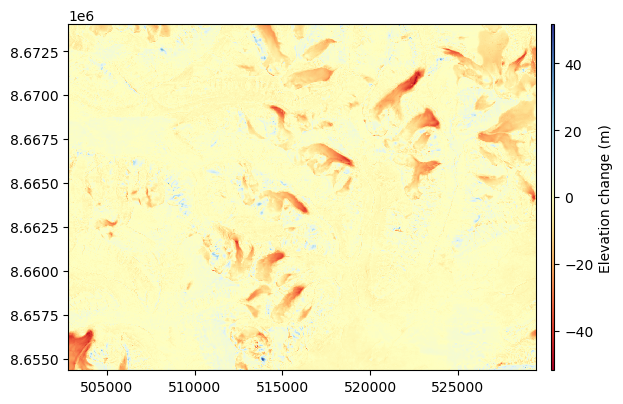

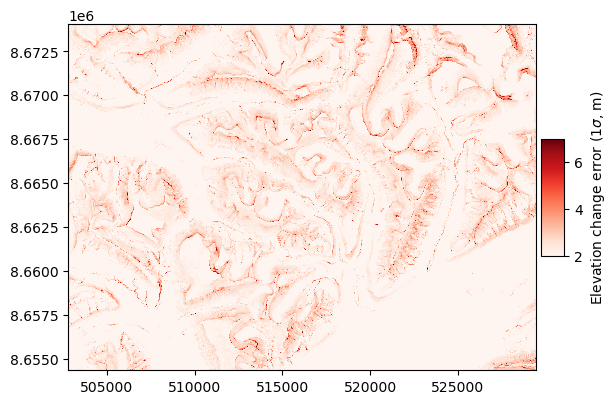

In [2]:
# Open files by instantiating DEM and Vector
# (DEMs are loaded lazily = only metadata but not array unless required)
dem_ref = xdem.DEM(fn_dem_ref)
dem_tba = xdem.DEM(fn_dem_tba)
vect_gla = gu.Vector(fn_glacier_outlines)

# Clip outlines to extent of reference DEM (method from GeoUtils)
vect_gla = vect_gla.crop(dem_ref, clip=True)

# Create a mask from glacier polygons (method from GeoUtils)
mask_gla = vect_gla.create_mask(dem_ref)

# We convert the vertical CRS of one DEM to the EGM96 geoid
dem_ref.to_vcrs("EGM96", force_source_vcrs="Ellipsoid")

# Align the two DEMs with a coregistration: 3D shift + 2nd-order 2D poly
mycoreg = xdem.coreg.NuthKaab() + xdem.coreg.Deramp(poly_order=2)
mycoreg.fit(dem_ref, dem_tba, inlier_mask=~mask_gla)
dem_aligned = mycoreg.apply(dem_tba)

# Get elevation difference
dh = dem_ref - dem_aligned

# Derive slope and curvature attributes
slope, maximum_curvature = xdem.terrain.get_terrain_attribute(
    dem_ref, attribute=["slope", "maximum_curvature"]
)

# Estimate elevation change error from stable terrain as a function of slope and curvature
dh_err = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dh, list_var=[slope, maximum_curvature], unstable_mask=mask_gla
)[0]

# Plot dh, glacier outlines and its error map
dh.plot(cmap="RdYlBu", cbar_title="Elevation change (m)")
vect_gla.plot(dh, fc='none', ec='k', lw=0.5)

dh_err.plot(ax="new", vmin=2, vmax=7, cmap="Reds", cbar_title=r"Elevation change error (1$\sigma$, m)")
vect_gla.plot(dh_err, fc='none', ec='k', lw=0.5)

# Save to file
dh_err.save("dh_error.tif")

In [3]:
import os
os.remove("dh_error.tif")

(quick-gallery)=
## More examples

To dive into more illustrated code, explore our gallery of examples that is composed of:
- An {ref}`examples-basic` section on simpler routines (terrain attributes, pre-defined coregistration and uncertainty pipelines),
- An {ref}`examples-advanced` section using advanced pipelines (for in-depth coregistration and uncertainty analysis).

See also the concatenated list of examples below.

```{eval-rst}
.. minigallery:: xdem.DEM
    :add-heading: Examples using DEMs
```